In [303]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor as MLPR
import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [304]:
df= pd.read_csv('network_backup_dataset.csv')
df.shape

(18588, 7)

In [305]:
df.head()

Week # Day of Week  Backup Start Time - Hour of Day Work-Flow-ID File Name  \
0       1      Monday                                1  work_flow_0    File_0   
1       1      Monday                                1  work_flow_2   File_12   
2       1      Monday                                1  work_flow_2   File_13   
3       1      Monday                                1  work_flow_2   File_14   
4       1      Monday                                1  work_flow_2   File_16   

   Size of Backup (GB)  Backup Time (hour)  
0                  0.0                   0  
1                  0.0                   0  
2                  0.0                   0  
3                  0.0                   0  
4                  0.0                   0

In [306]:
df.describe()

Week #  Backup Start Time - Hour of Day  Size of Backup (GB)  \
count  18588.000000                     18588.000000         18588.000000   
mean       7.998978                        10.948569             0.060984   
std        4.320367                         6.834062             0.104192   
min        1.000000                         1.000000             0.000000   
25%        4.000000                         5.000000             0.000000   
50%        8.000000                         9.000000             0.017180   
75%       12.000000                        17.000000             0.082143   
max       15.000000                        21.000000             1.008827   

       Backup Time (hour)  
count        18588.000000  
mean             0.927964  
std              0.938197  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              4.000000

In [307]:
df.tail()

Week # Day of Week  Backup Start Time - Hour of Day Work-Flow-ID  \
18583      15      Sunday                               21  work_flow_4   
18584      15      Sunday                               21  work_flow_4   
18585      15      Sunday                               21  work_flow_4   
18586      15      Sunday                               21  work_flow_4   
18587      15      Sunday                               21  work_flow_4   

      File Name  Size of Backup (GB)  Backup Time (hour)  
18583   File_29             0.151538                   1  
18584   File_27             0.148363                   1  
18585   File_26             0.198572                   2  
18586   File_25             0.199570                   2  
18587   File_24             0.201201                   2

In [308]:
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]
print(df_group)

                                 Size of Backup (GB)
Week # Day of Week Work-Flow-ID                     
1      Monday      work_flow_0              3.877791
                   work_flow_2              0.019199
                   work_flow_3              0.020530
                   work_flow_1             10.072163
                   work_flow_4              2.672759
       Tuesday     work_flow_3              0.023154
                   work_flow_2              0.013474
                   work_flow_4              2.965390
                   work_flow_0              4.204927
                   work_flow_1              0.805372
       Wednesday   work_flow_3              0.035634
                   work_flow_1              0.061776
                   work_flow_2              0.017966
                   work_flow_4              3.048706
                   work_flow_0              4.144235
       Thursday    work_flow_1              0.097006
                   work_flow_2              2.

In [309]:
workflow = [[],[],[],[],[]]
for index, row in df_group.iterrows():
    workflow[int(index[2][-1])].append(row[0])

In [313]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

def plot_workflow(y, n, title=''):
    data = []
    
    for i in range(5): #for each workflow
        trace = go.Scatter(x=list(range(1,n+1)), y=y[i][:n], mode='lines', 
                           line=dict(width=2), name=('work_flow_'+str(i)))
        data.append(trace)

    layout = go.Layout(title=title,
                       xaxis=dict(title='Day', dtick=7),
                       yaxis=dict(title='Backup sizes', ticks='outside'))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [314]:
plot_workflow(workflow, 20, 'Daily backup sizes for each workflow for 20 days')
plot_workflow(workflow, 105, 'Daily backup sizes for every workflows for 105 days')

In [315]:
def scaler_encoding(df):
    df["File Name"] = df["File Name"].str.split('_')
    df["File Name"] = df["File Name"].apply(lambda x: x[-1])
    
    df["Work-Flow-ID"] = df["Work-Flow-ID"].str.split('_')
    df["Work-Flow-ID"] = df["Work-Flow-ID"].apply(lambda x: x[-1])
    
    le = LabelEncoder()
    df["Day of Week"] = le.fit_transform(df["Day of Week"])
    return df,le



In [316]:
def one_hot_encoding(df):
    df['Day of Week'] = pd.Categorical(df['Day of Week'])
    dfDummies = pd.get_dummies(df['Day of Week'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)

    df['Work-Flow-ID'] = pd.Categorical(df['Work-Flow-ID'])
    dfDummies = pd.get_dummies(df['Work-Flow-ID'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)
    
    df['File Name'] = pd.Categorical(df['File Name'])
    dfDummies = pd.get_dummies(df['File Name'], prefix = 'category')
    df = pd.concat([df, dfDummies], axis=1)
    
    return df.drop(['Day of Week', 'Work-Flow-ID','File Name'], axis=1)

In [317]:
df_scaler_encoded,le = scaler_encoding(df)
df_onehot_encoded = one_hot_encoding(df)

In [318]:
def plot_ground_vs_fitted(y_true,y_pred):
    fig = plt.figure()  
    plt.scatter(range(len(y_true)),y_true,c='purple',marker='x',alpha=0.4,label='Ground Truth')
    plt.scatter(range(len(y_pred)),y_pred,c='red',marker='x',alpha=0.4,label='Fitted Truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()
    
def plot_residual_vs_fitted(y_true,y_pred):
    fig = plt.figure()  
    y_res = np.array(y_true)-np.array(y_pred)
    plt.scatter(range(len(y_res)),y_res,c='purple',alpha=0.4,marker='x',label='Residual')
    plt.scatter(range(len(y_pred)),y_pred,c='red',marker='x',alpha=0.4,label='Fitted Truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

In [319]:
def cross_validation_testing(model,X,y,plot):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    rmse_train_list, rmse_test_list = [],[]
    y_pred = []
    y_true = []

    # clf = LinearRegression()
    # scores = cross_val_score(clf, X, y, cv=10, scoring="neg_mean_squared_error")
    # print(scores.mean())

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train)
        rmse_train_list.append(mean_squared_error(y_train, model.predict(X_train)))
        rmse_test_list.append(mean_squared_error(y_test,model.predict(X_test)))
        y_pred+=list(model.predict(X_test))
        y_true+=list(y_test)

    rmse_train = np.sqrt(np.mean(rmse_train_list))
    rmse_test = np.sqrt(np.mean(rmse_test_list))
    if plot:
        plot_ground_vs_fitted(y_true,y_pred)
        plot_residual_vs_fitted(y_true,y_pred)
    return rmse_train,rmse_test,model

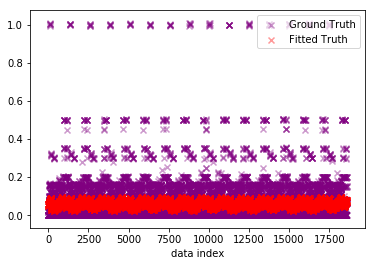

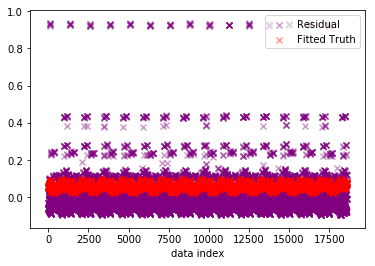

In [320]:
# Linear Regression
from sklearn.model_selection import cross_val_score
X = df_scaler_encoded.drop(['Size of Backup (GB)','Backup Time (hour)'],axis = 1)
y = df_scaler_encoded['Size of Backup (GB)']
rmse_train,rmse_test,_ = cross_validation_testing(LinearRegression(),X,y,plot=True)

In [140]:
print(rmse_train, rmse_test)

0.10306535429614527 0.10316544988003133


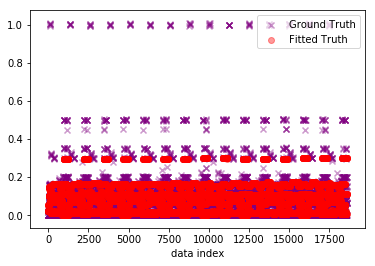

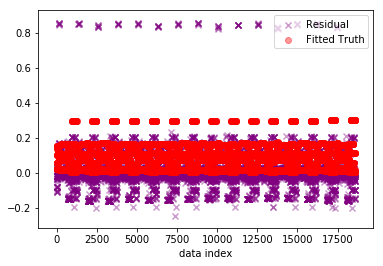

In [141]:
from sklearn.ensemble import RandomForestRegressor

X = df_scaler_encoded.drop(['Size of Backup (GB)','Backup Time (hour)'],axis = 1)
y = df_scaler_encoded['Size of Backup (GB)']

regr = RandomForestRegressor(max_depth=4, random_state=0, bootstrap = True,max_features=5,
                              n_estimators=20,oob_score=True)
rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y,plot=True)
oob_error = 1- model.oob_score_

In [142]:
print(rf_rmse_train, rf_rmse_test, oob_error)

0.07582598831582459 0.07605040868543311 0.5314969255914614


In [25]:
oob_error_list = []
rmse_test_list = []
min_rmse = 100000
for i in range(1,201):
    print("For ",i, " number of trees")
    oob_error = 0
    rmse_test = 0
    for j in range(1,6):
        print("For ",j, " number of features")
        regr = RandomForestRegressor(max_depth=4, random_state=0, bootstrap = True,max_features=j,
                              n_estimators=i,oob_score=True)
        rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y,plot=False)
        oob_error += (1- model.oob_score_)
        rmse_test += rf_rmse_test
        if rf_rmse_test<min_rmse:
            min_rmse = rf_rmse_test
            best_model = regr
    oob_error_list.append(oob_error/5)
    rmse_test_list.append(rmse_test/5)


For  1  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  2  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features
For  3  number of trees
For  1  number of features
For  2  number of features
For  3  number of features
For  4  number of features
For  5  number of features


KeyboardInterrupt: 

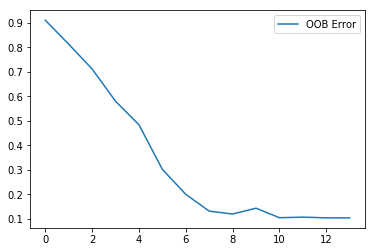

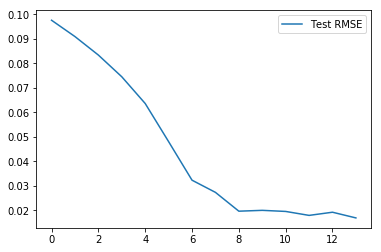

In [143]:
plt.plot(range(len(oob_error_list)),oob_error_list,label="OOB Error")
plt.legend(loc='upper right')
plt.show()

plt.plot(range(len(rmse_test_list)),rmse_test_list,label="Test RMSE")
plt.legend(loc='upper right')
plt.show()

In [144]:
print(np.min(oob_error_list),np.argmin(oob_error_list))


0.10376136992059082 13


In [145]:
print(np.min(rmse_test_list),np.argmin(rmse_test_list))

0.016906376230641746 13


In [146]:
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3, n_jobs=None, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [147]:
min_rmse

0.016906376230641746

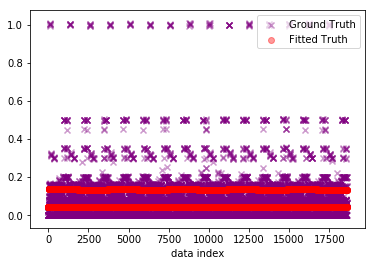

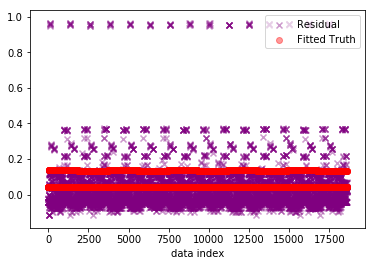

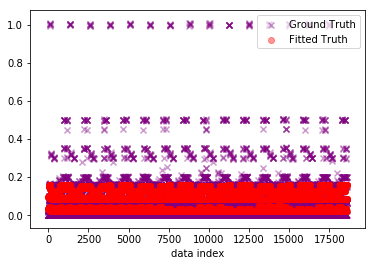

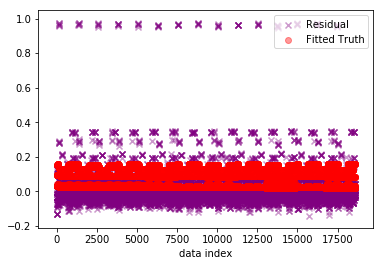

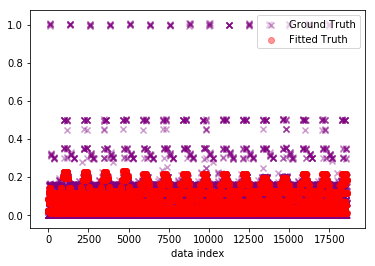

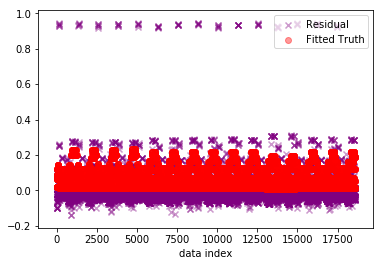

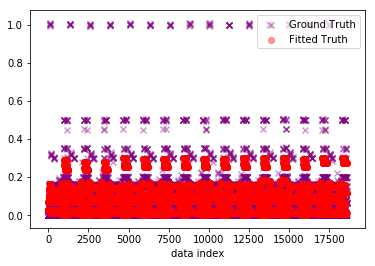

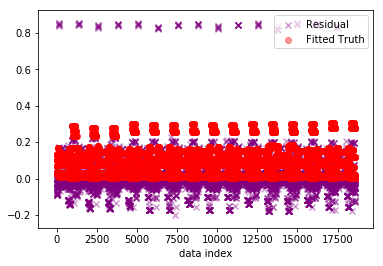

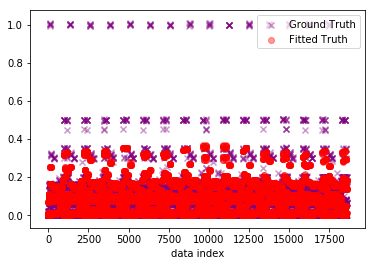

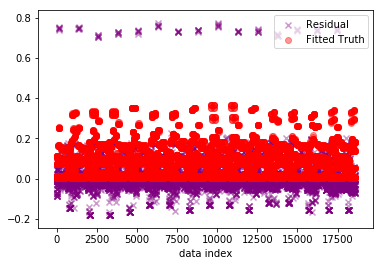

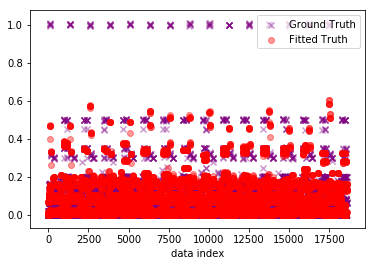

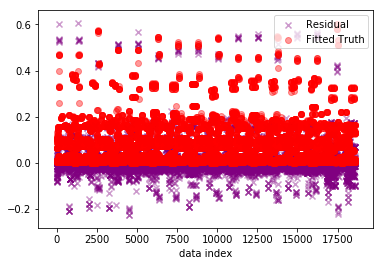

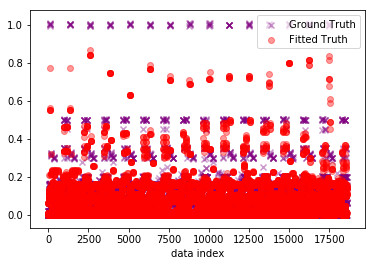

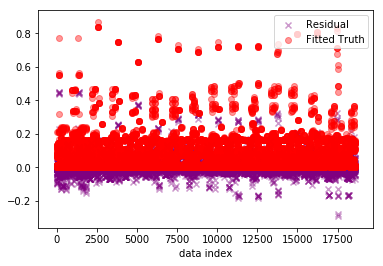

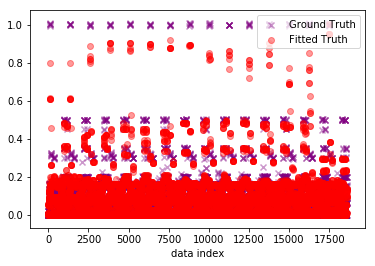

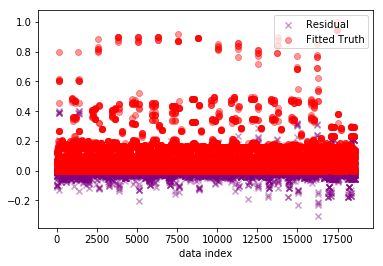

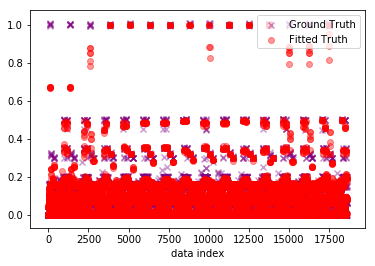

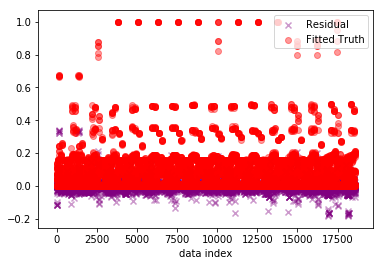

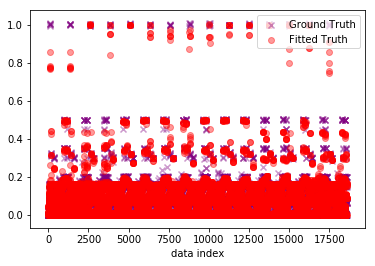

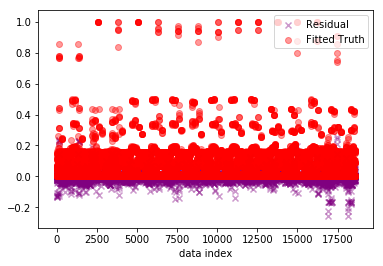

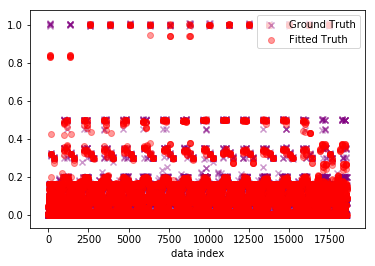

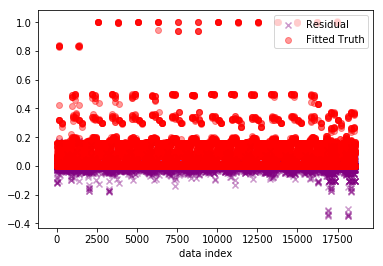

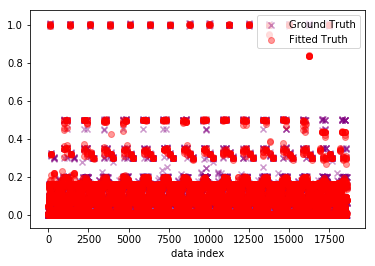

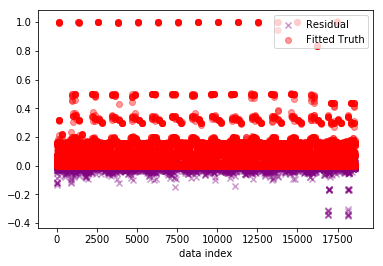

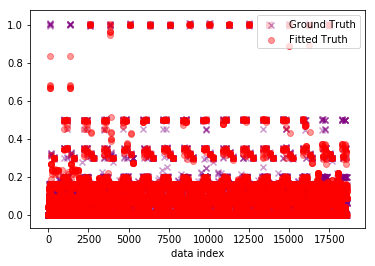

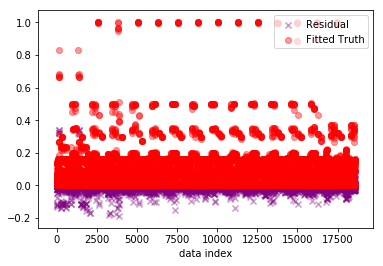

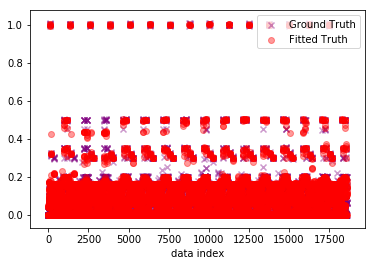

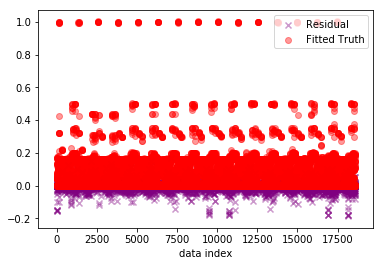

KeyboardInterrupt: 

In [31]:
# Experimenting on max_depth
# Sweeping from 1 to 10, with other parameters fixed
oob_error_list = []
rmse_test_list = []
min_rmse = 10000
for i in range(1,20):
    regr = RandomForestRegressor(max_depth=i, random_state=0, bootstrap = True,max_features=3,
                              n_estimators=6,oob_score=True)
    rf_rmse_train, rf_rmse_test,model = cross_validation_testing(regr,X,y,plot=True)
    if rf_rmse_test<min_rmse:
        min_rmse = rf_rmse_test
        best_model_2 = regr
    oob_error_list.append(1 - model.oob_score_)
    rmse_test_list.append(rf_rmse_test)

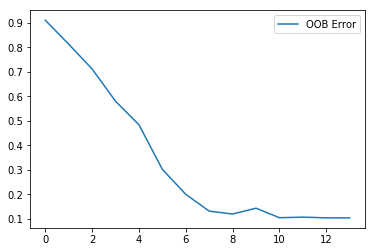

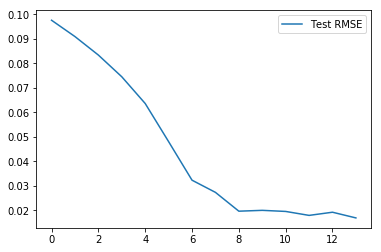

In [32]:
plt.plot(range(len(oob_error_list)),oob_error_list,label="OOB Error")
plt.legend(loc='upper right')
plt.show()

plt.plot(range(len(rmse_test_list)),rmse_test_list,label="Test RMSE")
plt.legend(loc='upper right')
plt.show()

In [33]:
print(np.min(rmse_test_list),np.argmin(rmse_test_list))

0.016906376230641746 13


In [34]:
best_model_2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=None, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

2.b.iv. Report the feature importances you got from the best random forest regression you find.

In [35]:
best_model_2.feature_importances_

array([0.00836884, 0.42830097, 0.27595823, 0.08511047, 0.20226149])

2.b.v Visualize your decision trees.


In [148]:
estimator = best_model.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator,out_file="tree.dot",
                feature_names=X.columns,
                filled=True,
                rounded=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
import os
# Install Graphviz and restart jupyter for this line to run
os.system('dot -Tpng tree.dot -o tree.png')



0

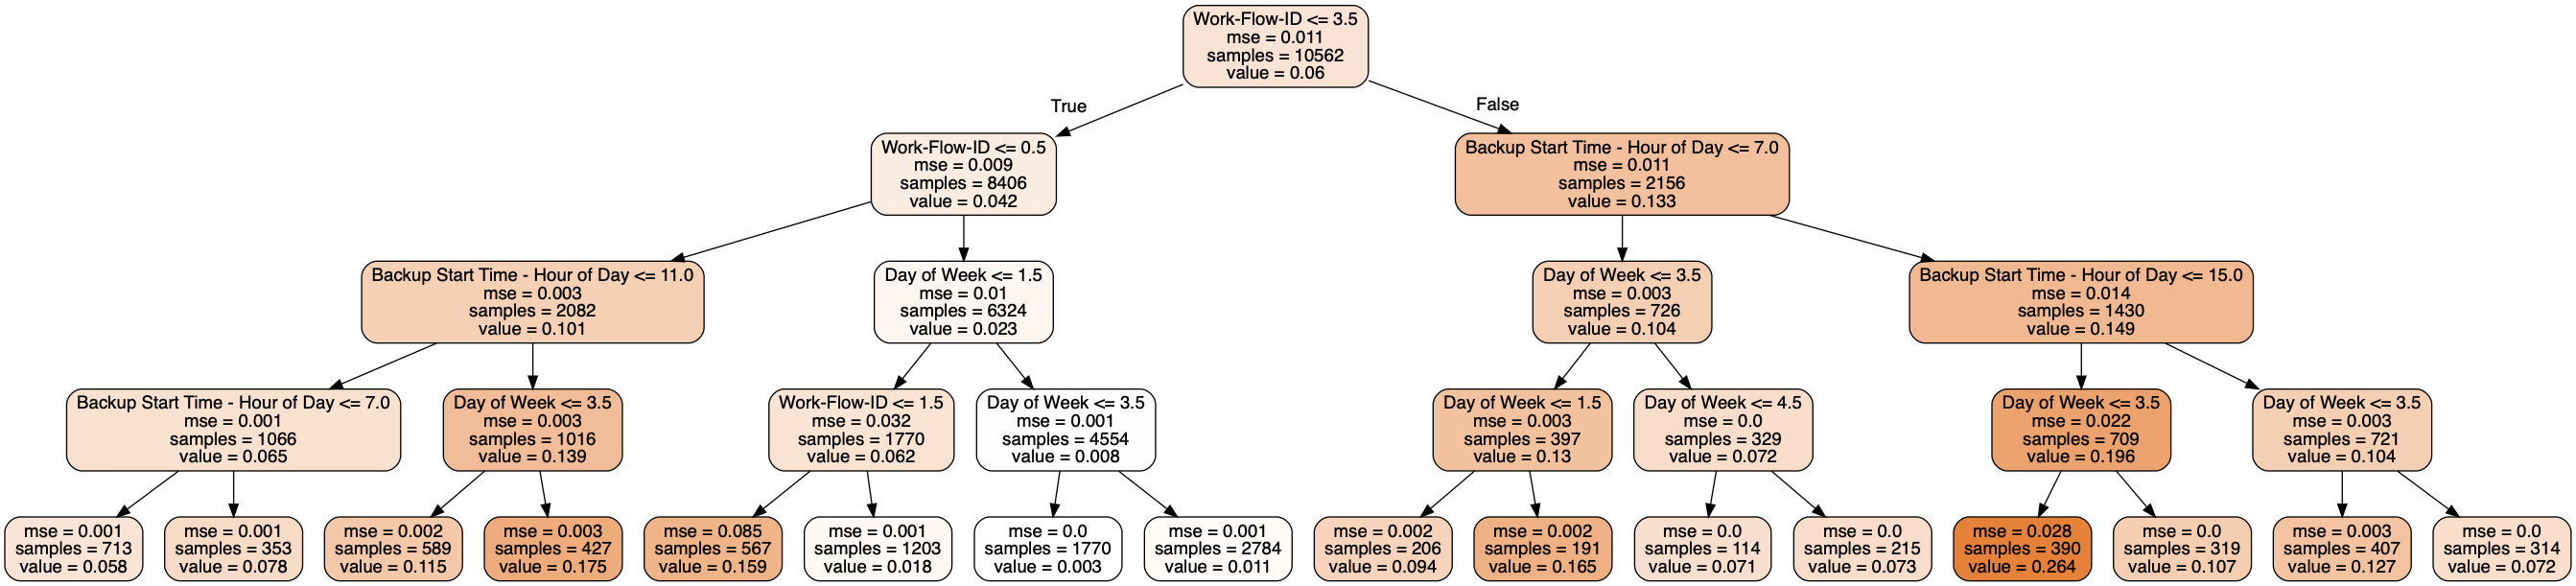

In [149]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

(c) Now use a neural network regression model (one hidden layer) with all features one-hot encoded. Parameters:
• Number of hidden units. Try [2, 5, 10, 50, 100, 150, 200, . . . , 600].
• Activation function (‘relu’, ‘logistic’, ‘tanh’)
Plot test-RMSE vs the number of hidden units for each activation function.
Report the best combination.

In [259]:
def MLP_model(hidden_units,activation):
    MLP_model=MLPR(hidden_layer_sizes=hidden_units,activation=activation)
    return MLP_model

<Figure size 432x288 with 0 Axes>

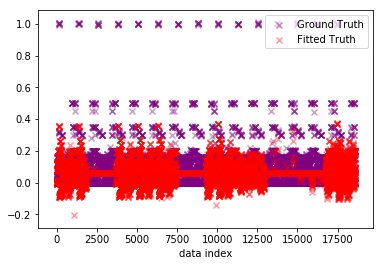

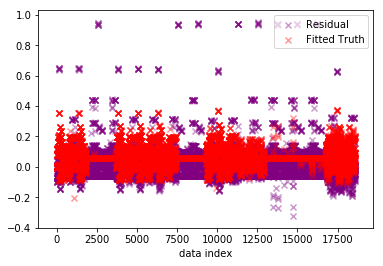

Train RMSE for 2 Hidden units and Activation: relu is =  0.08841820675813686
Test RMSE for 2 Hidden units and Activation: relu is =  0.08966545008477501


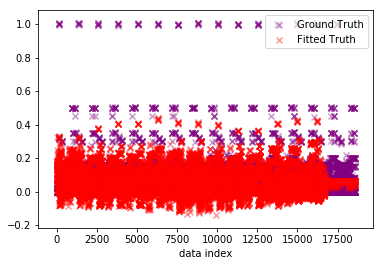

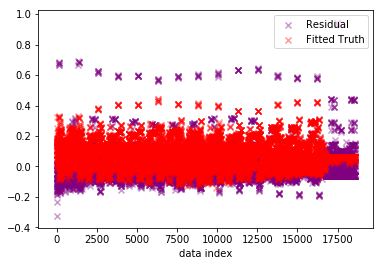

Train RMSE for 5 Hidden units and Activation: relu is =  0.07395021276068021
Test RMSE for 5 Hidden units and Activation: relu is =  0.07428355351162526


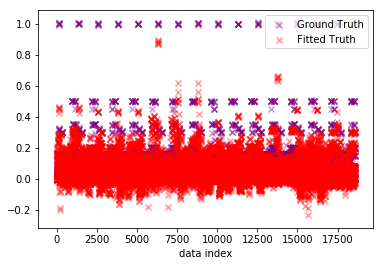

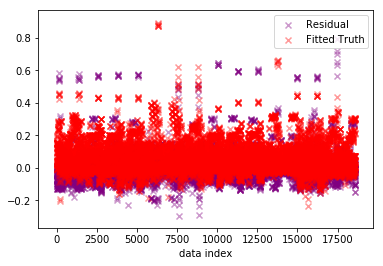

Train RMSE for 10 Hidden units and Activation: relu is =  0.06441313996531813
Test RMSE for 10 Hidden units and Activation: relu is =  0.06514280980240812


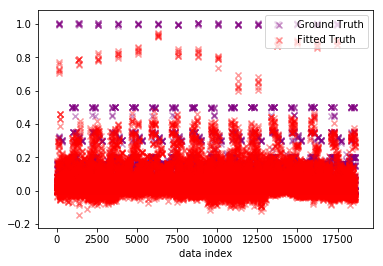

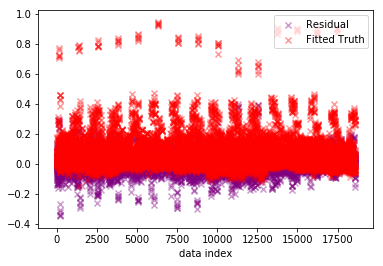

Train RMSE for 50 Hidden units and Activation: relu is =  0.03978897567782655
Test RMSE for 50 Hidden units and Activation: relu is =  0.04474060227356015


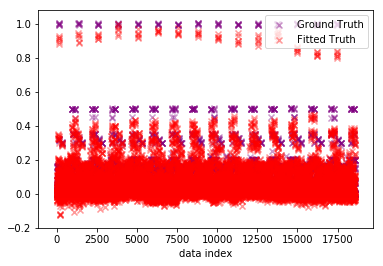

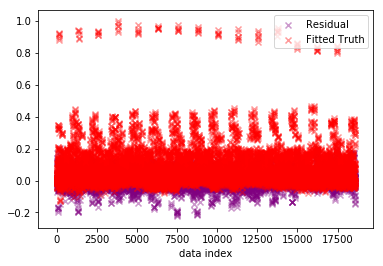

Train RMSE for 100 Hidden units and Activation: relu is =  0.029570327485074224
Test RMSE for 100 Hidden units and Activation: relu is =  0.03311019750392102


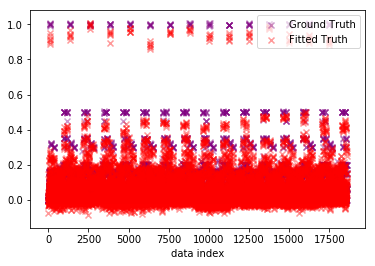

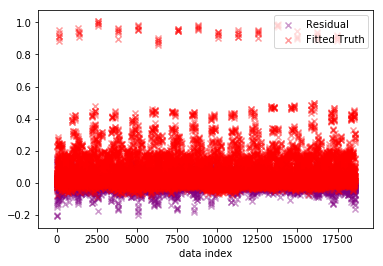

Train RMSE for 150 Hidden units and Activation: relu is =  0.024625735295600106
Test RMSE for 150 Hidden units and Activation: relu is =  0.028147194695741885


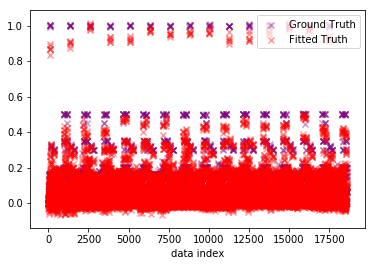

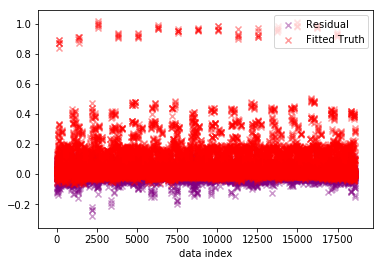

Train RMSE for 200 Hidden units and Activation: relu is =  0.020870801808297177
Test RMSE for 200 Hidden units and Activation: relu is =  0.025542429699539633


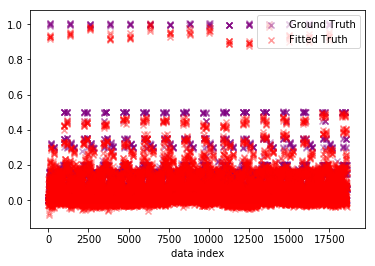

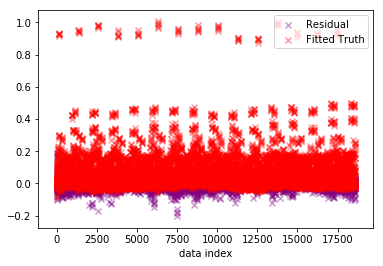

Train RMSE for 300 Hidden units and Activation: relu is =  0.019145436962833995
Test RMSE for 300 Hidden units and Activation: relu is =  0.02316916030857981


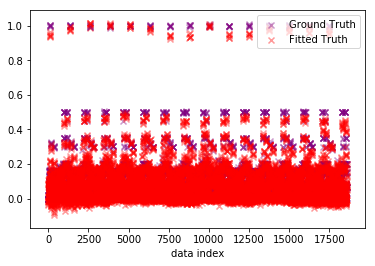

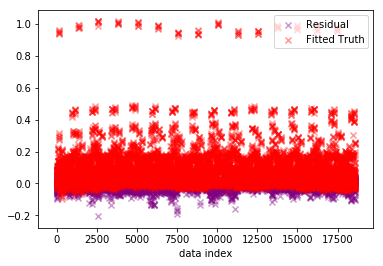

Train RMSE for 400 Hidden units and Activation: relu is =  0.018203174961728064
Test RMSE for 400 Hidden units and Activation: relu is =  0.022343818242190727


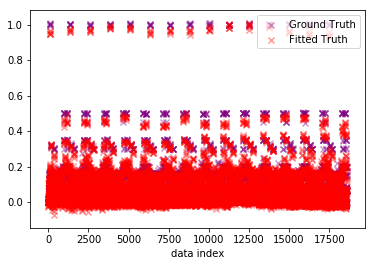

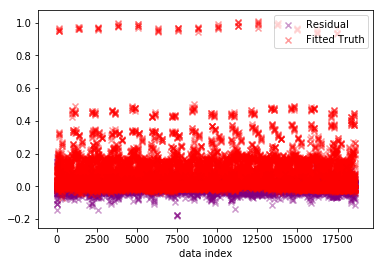

Train RMSE for 500 Hidden units and Activation: relu is =  0.015921106721378454
Test RMSE for 500 Hidden units and Activation: relu is =  0.01994274947484271


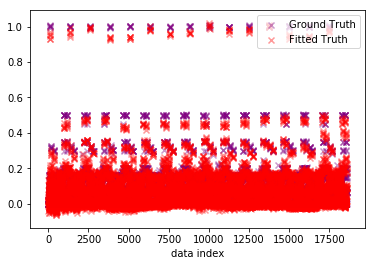

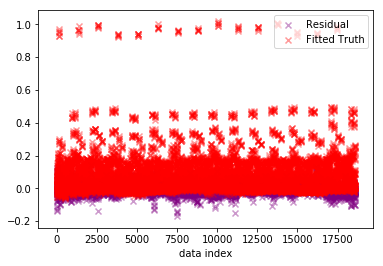

Train RMSE for 600 Hidden units and Activation: relu is =  0.017485400279973883
Test RMSE for 600 Hidden units and Activation: relu is =  0.02011599561065632


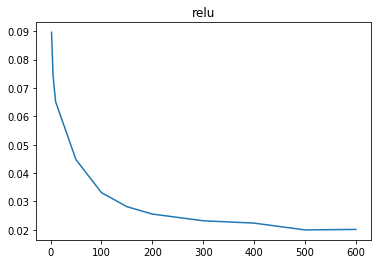

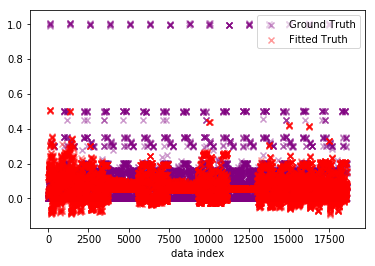

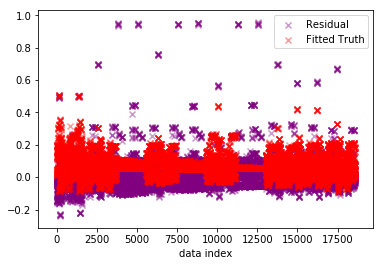

Train RMSE for 2 Hidden units and Activation: logistic is =  0.08129363332344416
Test RMSE for 2 Hidden units and Activation: logistic is =  0.08181500444787941


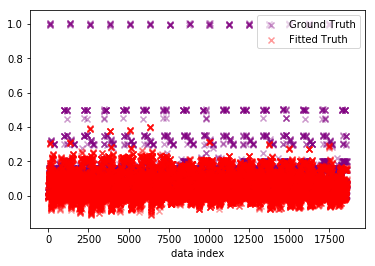

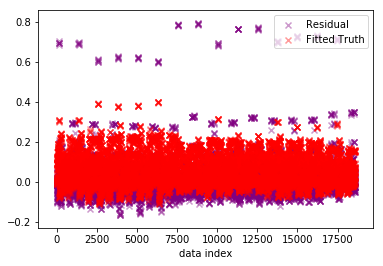

Train RMSE for 5 Hidden units and Activation: logistic is =  0.07124272219378454
Test RMSE for 5 Hidden units and Activation: logistic is =  0.07196298431599246


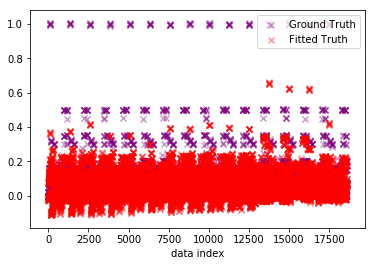

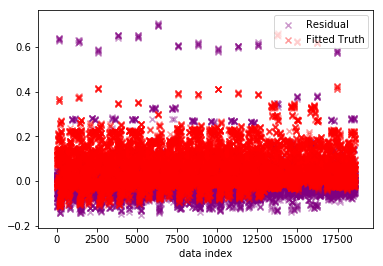

Train RMSE for 10 Hidden units and Activation: logistic is =  0.06331162459036646
Test RMSE for 10 Hidden units and Activation: logistic is =  0.06410434814447791


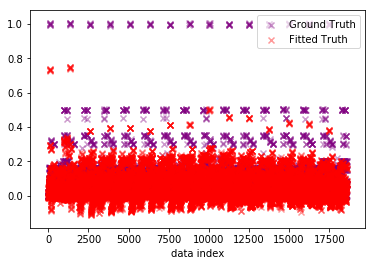

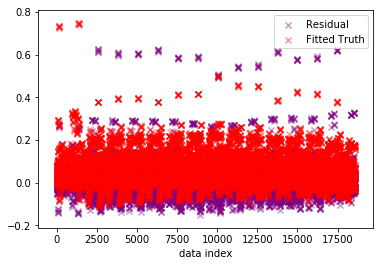

Train RMSE for 50 Hidden units and Activation: logistic is =  0.06395189947215296
Test RMSE for 50 Hidden units and Activation: logistic is =  0.063789293521998


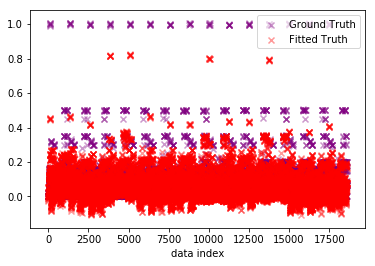

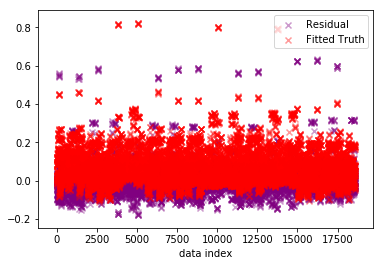

Train RMSE for 100 Hidden units and Activation: logistic is =  0.06020934634664528
Test RMSE for 100 Hidden units and Activation: logistic is =  0.060328617318963385


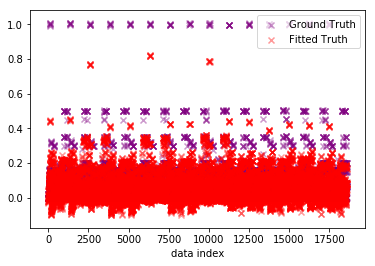

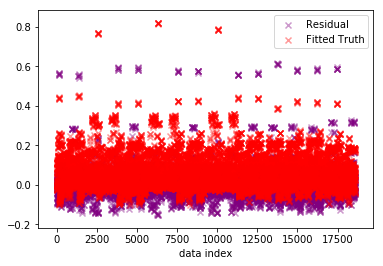

Train RMSE for 150 Hidden units and Activation: logistic is =  0.058490590401386426
Test RMSE for 150 Hidden units and Activation: logistic is =  0.05945787334048091


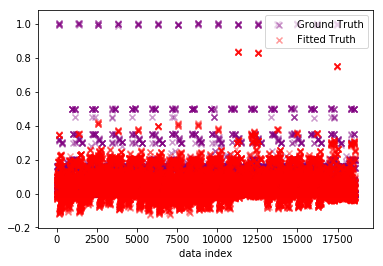

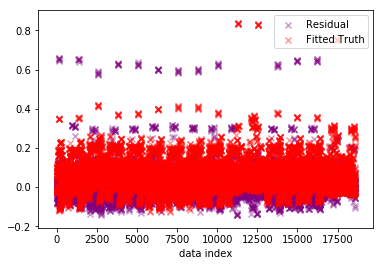

Train RMSE for 200 Hidden units and Activation: logistic is =  0.06401322406584897
Test RMSE for 200 Hidden units and Activation: logistic is =  0.06432432696257852


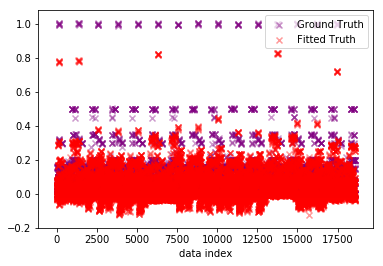

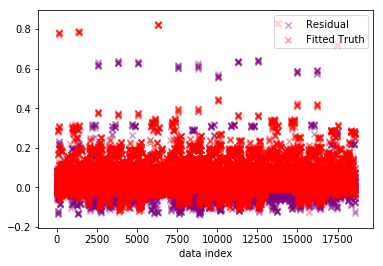

Train RMSE for 300 Hidden units and Activation: logistic is =  0.05825886675506815
Test RMSE for 300 Hidden units and Activation: logistic is =  0.05940629904072118


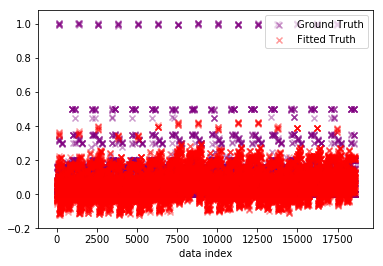

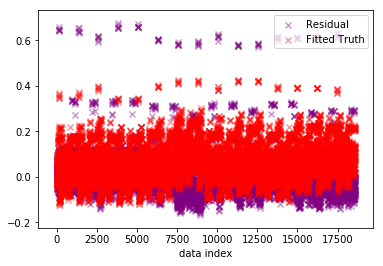

Train RMSE for 400 Hidden units and Activation: logistic is =  0.07223729117712266
Test RMSE for 400 Hidden units and Activation: logistic is =  0.07230515012040861


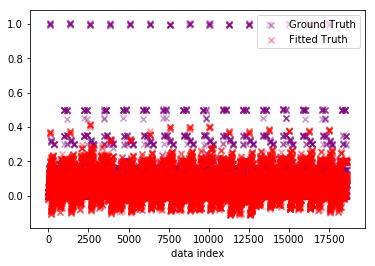

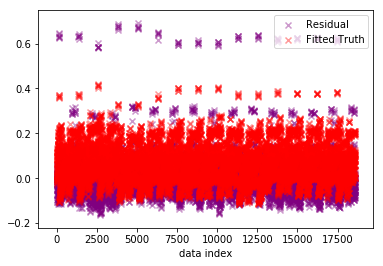

Train RMSE for 500 Hidden units and Activation: logistic is =  0.0710000216760998
Test RMSE for 500 Hidden units and Activation: logistic is =  0.07108686735399951


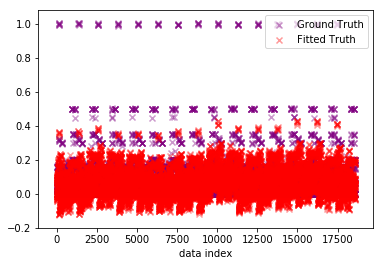

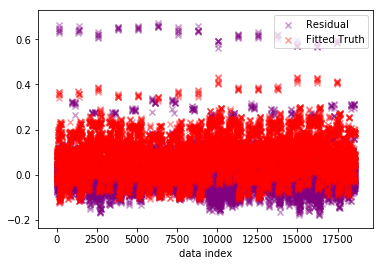

Train RMSE for 600 Hidden units and Activation: logistic is =  0.07295413702694545
Test RMSE for 600 Hidden units and Activation: logistic is =  0.0730056947915052


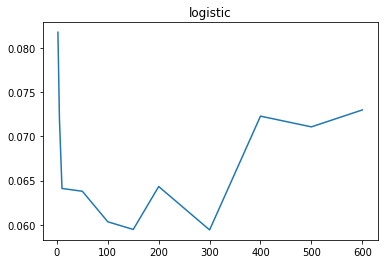

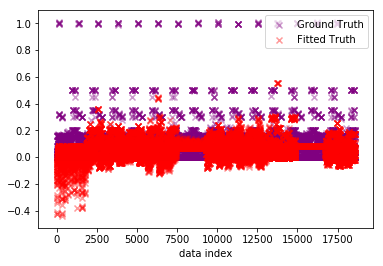

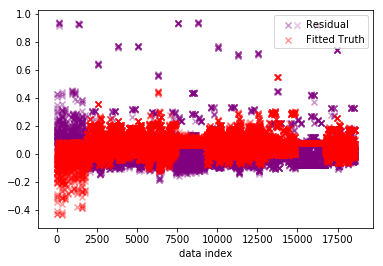

Train RMSE for 2 Hidden units and Activation: tanh is =  0.08384408154139526
Test RMSE for 2 Hidden units and Activation: tanh is =  0.08677019825291143


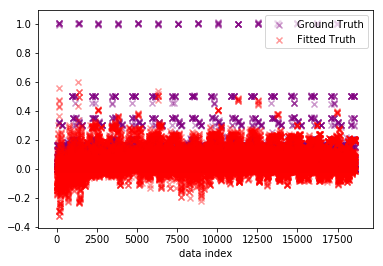

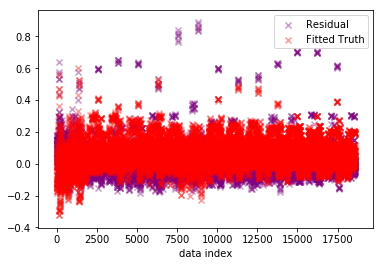

Train RMSE for 5 Hidden units and Activation: tanh is =  0.07254169423883083
Test RMSE for 5 Hidden units and Activation: tanh is =  0.07548201366490202


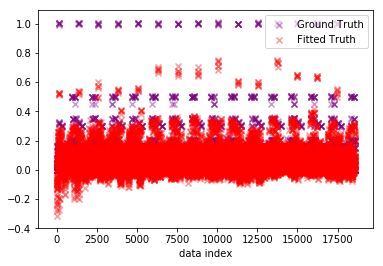

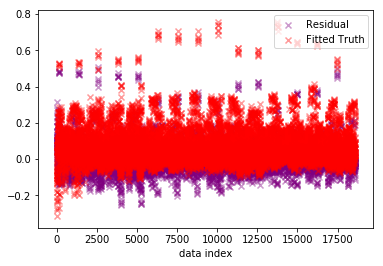

Train RMSE for 10 Hidden units and Activation: tanh is =  0.05289582551686063
Test RMSE for 10 Hidden units and Activation: tanh is =  0.05621955219771206


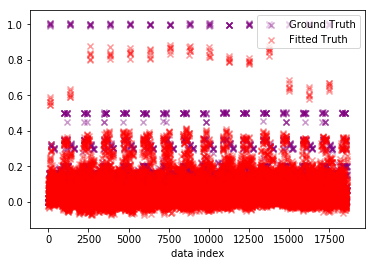

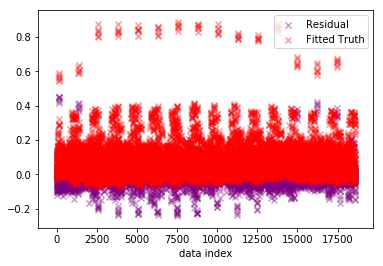

Train RMSE for 50 Hidden units and Activation: tanh is =  0.04015225549561528
Test RMSE for 50 Hidden units and Activation: tanh is =  0.04350508048443337


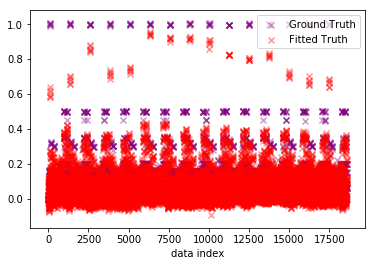

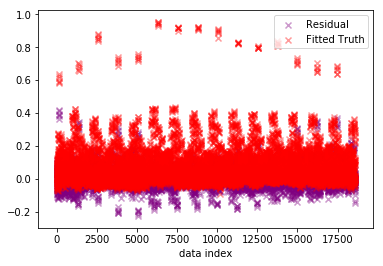

Train RMSE for 100 Hidden units and Activation: tanh is =  0.03516152109154982
Test RMSE for 100 Hidden units and Activation: tanh is =  0.039019092933521


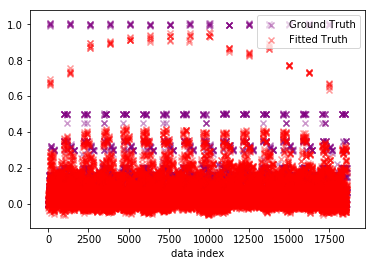

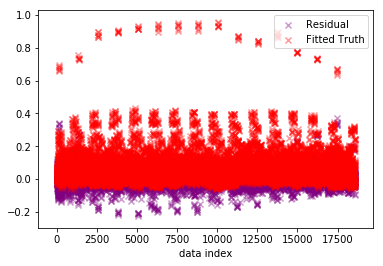

Train RMSE for 150 Hidden units and Activation: tanh is =  0.033334197351370796
Test RMSE for 150 Hidden units and Activation: tanh is =  0.03644276370583232


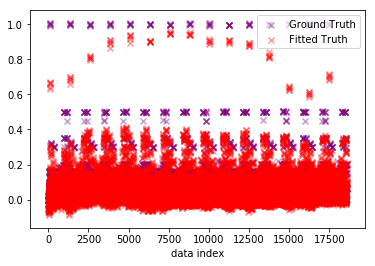

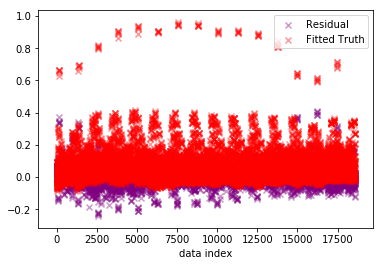

Train RMSE for 200 Hidden units and Activation: tanh is =  0.037627751351045534
Test RMSE for 200 Hidden units and Activation: tanh is =  0.03909618707659477


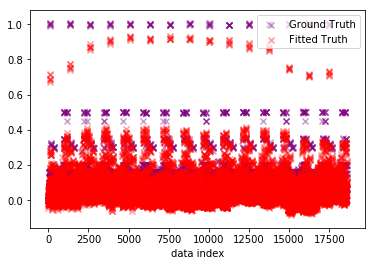

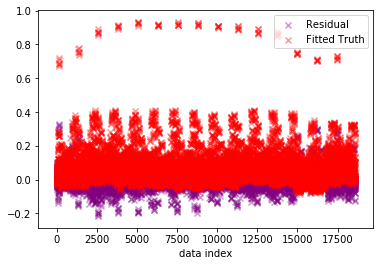

Train RMSE for 300 Hidden units and Activation: tanh is =  0.03633941199984668
Test RMSE for 300 Hidden units and Activation: tanh is =  0.03836566965459148


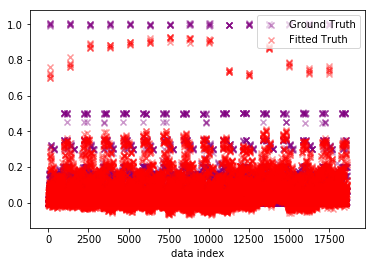

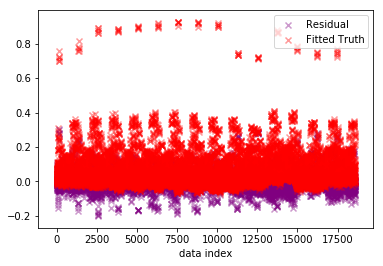

Train RMSE for 400 Hidden units and Activation: tanh is =  0.03690641486271769
Test RMSE for 400 Hidden units and Activation: tanh is =  0.038025863046630054


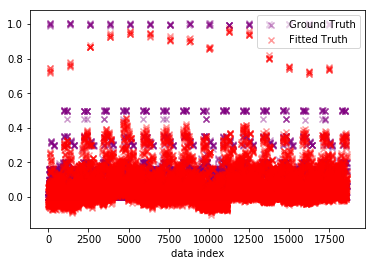

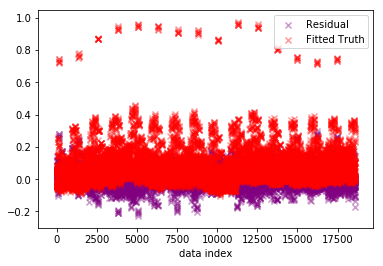

Train RMSE for 500 Hidden units and Activation: tanh is =  0.043550648183044015
Test RMSE for 500 Hidden units and Activation: tanh is =  0.04271434931253474


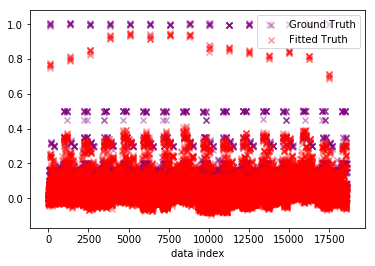

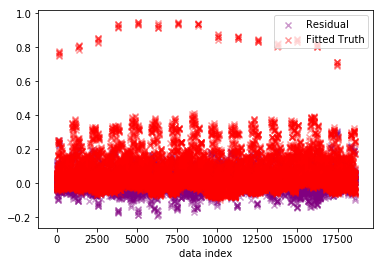

Train RMSE for 600 Hidden units and Activation: tanh is =  0.04034371559907949
Test RMSE for 600 Hidden units and Activation: tanh is =  0.04050965039850504


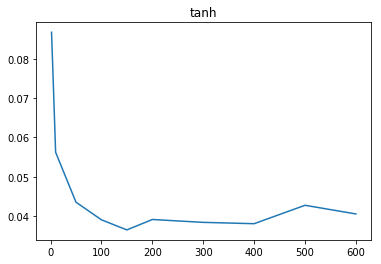

In [260]:


plt.figure()
X = df_onehot_encoded.drop(['Size of Backup (GB)'],axis = 1)
y = df_onehot_encoded['Size of Backup (GB)']



activations=['relu','logistic','tanh']
hidden_units=[2,5,10,50,100,150,200,300,400,500,600]
 

for act in activations:
    nn_rmse_test=[]
    for i in hidden_units:
        model=MLP_model(i,act)
        rmse_train,rmse_test,_ = cross_validation_testing(model,X,y,plot=True)
        print("Train RMSE for", i, "Hidden units and Activation:", act, "is = ", rmse_train)
        print("Test RMSE for", i, "Hidden units and Activation:", act, "is = ", rmse_test)
        nn_rmse_test.append(rmse_test)
    plt.title(act)
    plt.plot(hidden_units,nn_rmse_test)
    plt.show()
        



In [332]:
Xs, ys = [], []
for key, value in df.groupby('Work-Flow-ID').groups.items():
    group = df.loc[value].drop('Work-Flow-ID', axis=1).reset_index(drop=True)
    Xs.append(group.drop('Size of Backup (GB)', axis=1))
    ys.append(group[['Size of Backup (GB)']])


In [321]:
 
for i in range(len(ys)):
    rmse_train, rmse_test,_ = cross_validation_testing(LinearRegression(), Xs[i], ys[i],plot=False)
    print("%s: RMSE_train = %f RMSE_test = %f" % ('work_flow_'+str(i), rmse_train, rmse_test))


work_flow_0: RMSE_train = 0.033652 RMSE_test = 0.033992
work_flow_1: RMSE_train = 0.101801 RMSE_test = 0.102025
work_flow_2: RMSE_train = 0.025513 RMSE_test = 0.025605
work_flow_3: RMSE_train = 0.005846 RMSE_test = 0.005863
work_flow_4: RMSE_train = 0.101027 RMSE_test = 0.101600


In [322]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degrees = range(2, 10)
rmses_train, rmses_test = [], []
for i in range(len(ys)):
    rmses_train.append([])
    rmses_test.append([])
    for degree in degrees:
        model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
        rmse_train, rmse_test,_ = cross_validation_testing(model, Xs[i], ys[i],plot=False)
        rmses_train[i].append(rmse_train)
        rmses_test[i].append(rmse_test)

In [348]:
rmses_test[4] = temp

In [349]:
temp = rmses_test[4]
rmses_test[4] = rmses_test[2]

for i in range(5,8):
    rmses_test[4][i]+=10*i
print(rmses_test)

[[0.02837780342482536, 0.01879346946694996, 0.013001453803909664, 0.017085792198578004, 0.0993512569567584, 0.357669532758167, 2.0653944977806025, 5.676764267022556], [0.02520899466013547, 0.012067384874198752, 0.003066561762850526, 0.003408208902597347, 0.03766553606526838, 1.6238775224475597, 3.0702818751578653, 190.6600979563646], [0.023346977434155865, 0.018281019621779828, 0.016949541911150827, 0.017068735394344663, 80.03973337520439, 283.2163559529977, 422.5120766555896, 593.3168566117786], [0.005614846587344111, 0.005141471775842346, 0.004827480728187055, 0.016569154456757124, 0.45165092543260205, 2.269900457827503, 7.151154331124094, 8.722326429101962], [0.023346977434155865, 0.018281019621779828, 0.016949541911150827, 0.017068735394344663, 80.03973337520439, 283.2163559529977, 422.5120766555896, 593.3168566117786]]


In [346]:
def plot_metric(y, x, metric=''):
    data = []
    
    for i in range(len(y)):
        trace = go.Scatter(x=list(x), y=y[i], mode='lines', 
                           line=dict(width=2), name=('work_flow_'+str(i)))
        data.append(trace)

    layout = go.Layout(title=metric+' VS Degree',
                       xaxis=dict(title='Degree', dtick=1),
                       yaxis=dict(title=metric))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [337]:
plot_metric(rmses_train, degrees, 'RMSE_Train')
plot_metric(rmses_test, degrees, 'RMSE_Test')

In [352]:
plot_metric(rmses_train, degrees[:5], 'RMSE_Train')
plot_metric(rmses_test, degrees[:5], 'RMSE_Test')

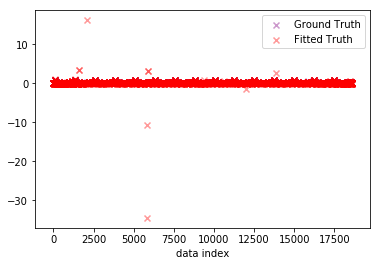

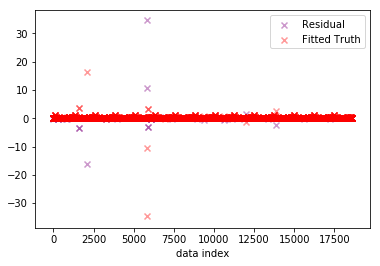

In [258]:
X = df.drop('Size of Backup (GB)', axis=1)
y = df[['Size of Backup (GB)']]
model = make_pipeline(PolynomialFeatures(degree=7, include_bias=False), LinearRegression())
kf = KFold(n_splits=10)
y_pred, y_true = [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model.fit(X_train, y_train)
    for num in model.predict(X_test).tolist():
        y_pred.append(num)
    for num in y_test.values.tolist():
        y_true.append(num)
plot_ground_vs_fitted(y_true,y_pred)
plot_residual_vs_fitted(y_true,y_pred)

(e) Use k-nearest neighbor regression and find the best parameter.


<Figure size 432x288 with 0 Axes>

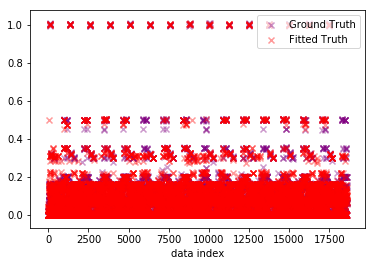

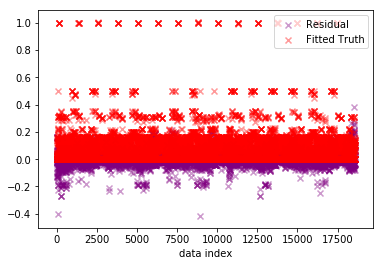

Train RMSE for 2  neighbours = 0.009748076291782953
Test RMSE 0.029600278177349778


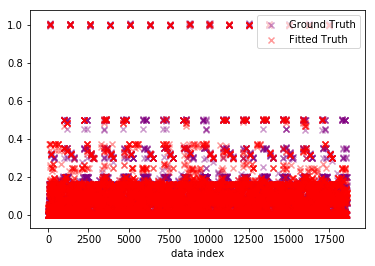

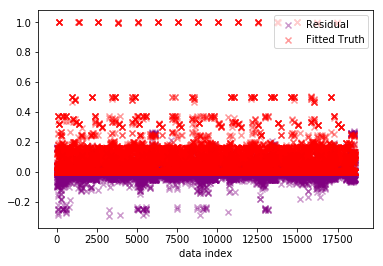

Train RMSE for 3  neighbours = 0.01247542330185669
Test RMSE 0.03231040379935868


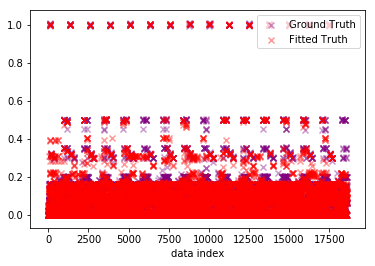

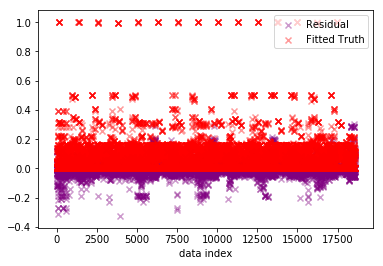

Train RMSE for 4  neighbours = 0.013970989877003091
Test RMSE 0.03152996229099001


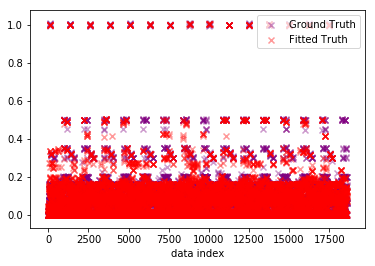

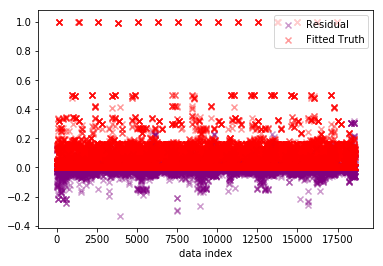

Train RMSE for 5  neighbours = 0.014389906251551485
Test RMSE 0.02976856605197938


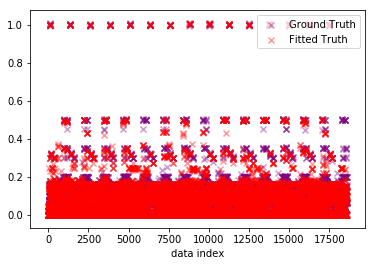

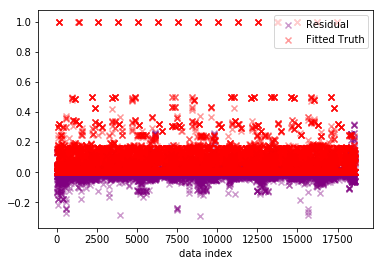

Train RMSE for 6  neighbours = 0.014138263062027584
Test RMSE 0.02819073268857089


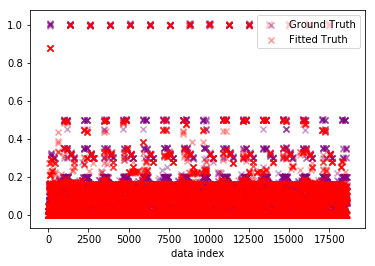

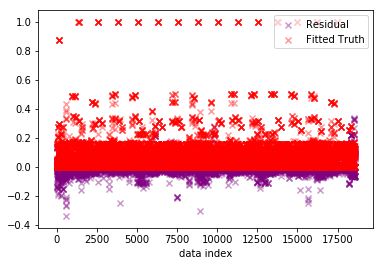

Train RMSE for 7  neighbours = 0.013924596210132053
Test RMSE 0.02716008946626608


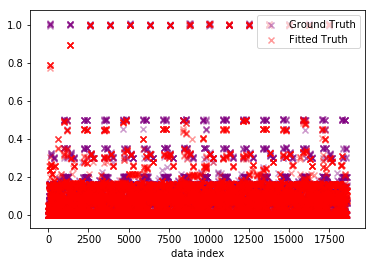

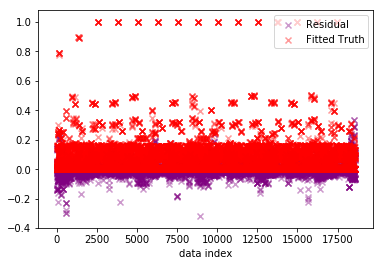

Train RMSE for 8  neighbours = 0.01404897680524547
Test RMSE 0.02688074794528538


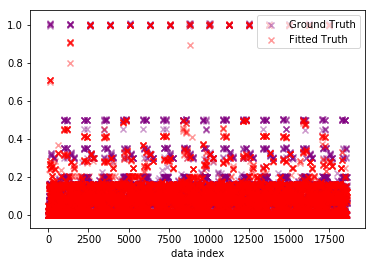

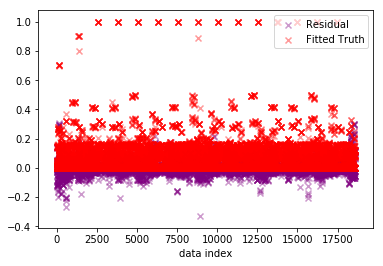

Train RMSE for 9  neighbours = 0.014606768106967784
Test RMSE 0.02741537965544601


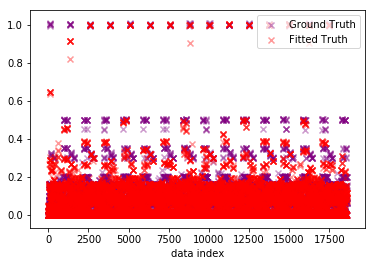

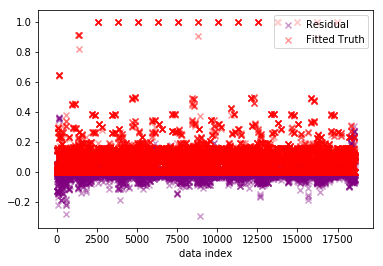

Train RMSE for 10  neighbours = 0.015598095784047753
Test RMSE 0.0287919553302838


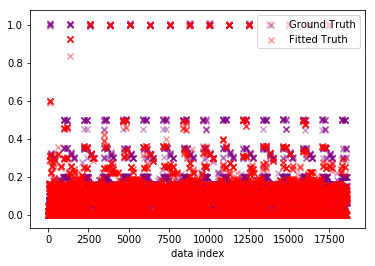

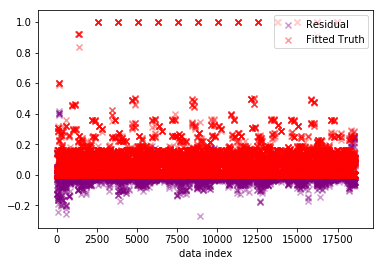

Train RMSE for 11  neighbours = 0.016786644891622453
Test RMSE 0.03020264925764733


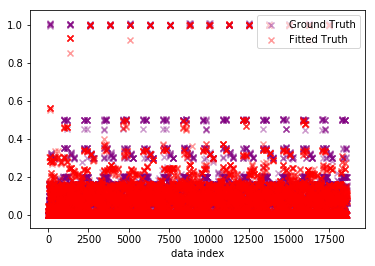

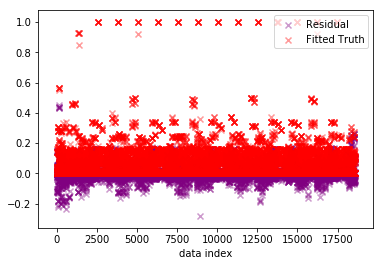

Train RMSE for 12  neighbours = 0.01769035993907844
Test RMSE 0.03180150905484143


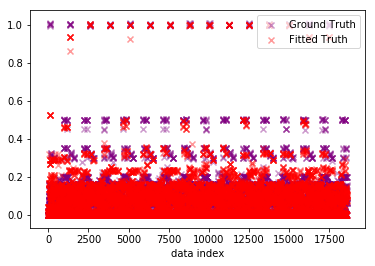

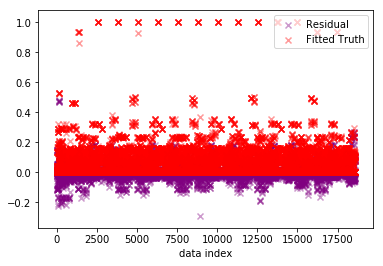

Train RMSE for 13  neighbours = 0.018406657099892268
Test RMSE 0.03314988428446555


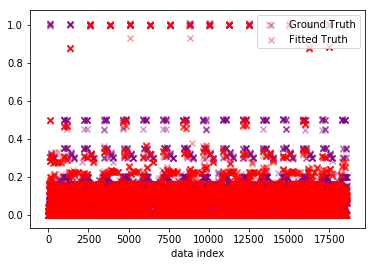

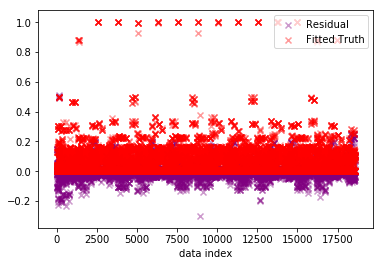

Train RMSE for 14  neighbours = 0.018889848655368486
Test RMSE 0.03412053758530458


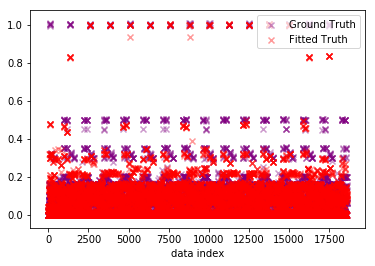

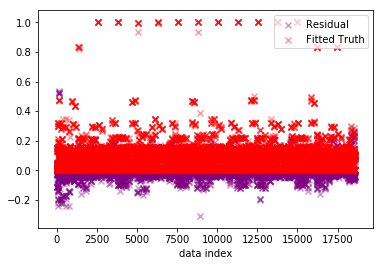

Train RMSE for 15  neighbours = 0.01938564607118386
Test RMSE 0.03523866991795542


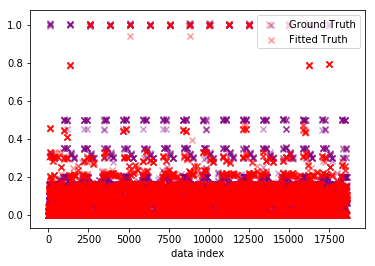

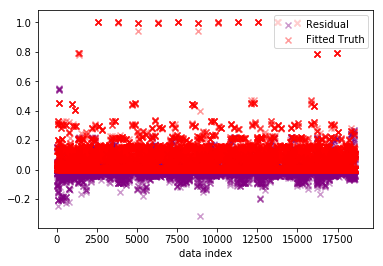

Train RMSE for 16  neighbours = 0.019957930152601736
Test RMSE 0.03606861473277587


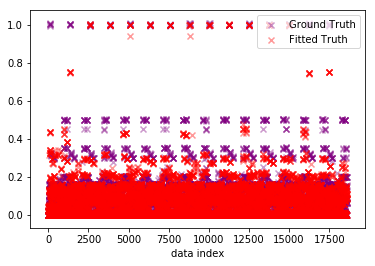

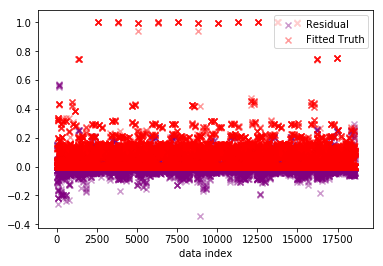

Train RMSE for 17  neighbours = 0.020644355824624067
Test RMSE 0.03675349188264677


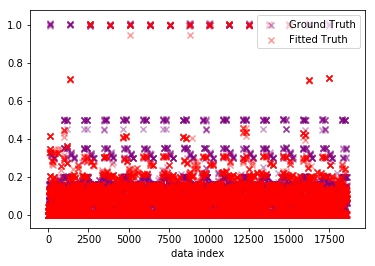

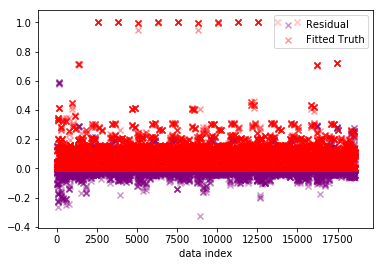

Train RMSE for 18  neighbours = 0.02140477529275484
Test RMSE 0.03754348848235362


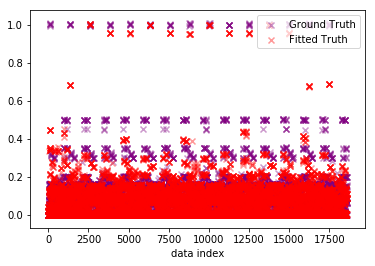

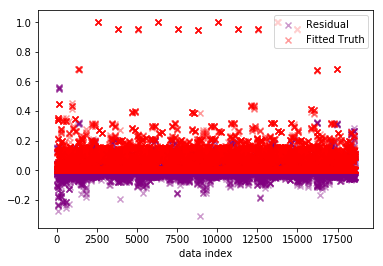

Train RMSE for 19  neighbours = 0.022087493364981926
Test RMSE 0.03818646171496168


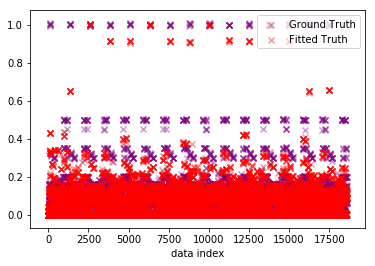

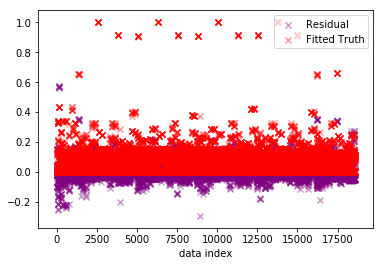

Train RMSE for 20  neighbours = 0.022640725819767043
Test RMSE 0.03898975461461182


In [261]:
from sklearn.neighbors import KNeighborsRegressor as KNR

plt.figure()
X = df_onehot_encoded.drop(['Size of Backup (GB)'],axis = 1)
y = df_onehot_encoded['Size of Backup (GB)']
rmses_test,rmses_train=[],[]
for i in range(2,21):
    model=KNR(n_neighbors=i)
    rmse_train,rmse_test,_ = cross_validation_testing(model,X,y,plot=True)
    print("Train RMSE for",i," neighbours =",rmse_train)
    print("Test RMSE", rmse_test)
    rmses_train.append(rmse_train)
    rmses_test.append(rmse_test)



<function matplotlib.pyplot.show(*args, **kw)>

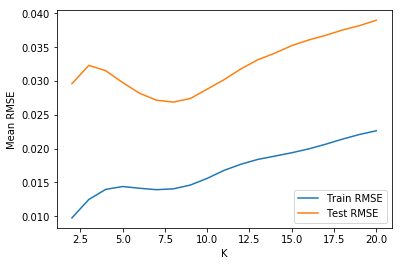

In [266]:
plt.figure()
plt.plot(list(range(2,21)),rmses_train,label='Train RMSE')
plt.plot(list(range(2,21)),rmses_test,label='Test RMSE')
plt.xlabel('K')
plt.ylabel('Mean RMSE')
plt.legend(loc='lower right')
plt.show